<a href="https://colab.research.google.com/github/Soorajb19/ImageTo3Dmodel/blob/main/To_3DModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# Cell 1: Install dependencies
!pip install -q torch torchvision torchaudio
!pip install -q onnxruntime
!pip install -q rembg
!pip install -q git+https://github.com/openai/shap-e.git
!pip install -q trimesh PyMCubes matplotlib numpy pillow

import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
from google.colab import files
import trimesh

from rembg import remove

from shap_e.diffusion.sample import sample_latents
from shap_e.diffusion.gaussian_diffusion import diffusion_from_config
from shap_e.models.download import load_model, load_config
from shap_e.util.image_util import load_image
from shap_e.util.notebooks import decode_latent_mesh

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [27]:
from mpl_toolkits.mplot3d import Axes3D

In [14]:
def upload_and_display_image():
    print("Please upload a JPG or PNG image...")
    uploaded = files.upload()
    if not uploaded:
        raise ValueError("No file was uploaded")

    image_path = list(uploaded.keys())[0]
    if not image_path.lower().endswith(('.jpg', '.jpeg', '.png')):
        raise ValueError("Please upload only JPG or PNG images")

    img = Image.open(image_path)
    if img.mode != 'RGB':
        img = img.convert('RGB')

    plt.imshow(img)
    plt.axis('off')
    plt.title("Uploaded Image")
    plt.show()

    return image_path, img

In [15]:
def remove_background(input_image):
    print("Removing background...")
    output = remove(np.array(input_image))
    output_img = Image.fromarray(output)
    output_img.save("object_extracted.png")

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(input_image)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(output_img)
    plt.title("Background Removed")
    plt.axis("off")
    plt.show()

    return output_img

In [16]:
def generate_latents(processed_image, device):
    print(f"Using device: {device}")
    model = load_model('image300M', device=device)
    diffusion = diffusion_from_config(load_config('diffusion'))

    temp_img_path = "temp_image.png"
    processed_image.save(temp_img_path)
    image_tensor = load_image(temp_img_path)

    latents = sample_latents(
        batch_size=1,
        model=model,
        diffusion=diffusion,
        guidance_scale=3.0,
        model_kwargs=dict(images=[image_tensor]),
        progress=True,
        clip_denoised=True,
        use_fp16=True,
        use_karras=True,
        karras_steps=64,
        sigma_min=1e-3,
        sigma_max=160,
        s_churn=0,
    )

    return latents

In [29]:
def export_and_visualize_mesh(latents, filename, device):
    print("Exporting mesh using transmitter model...")
    try:
        decoder = load_model('transmitter', device=device)
        mesh_data = decode_latent_mesh(decoder, latents[0])
        mesh = trimesh.Trimesh(
            vertices=mesh_data.verts.cpu().numpy(),
            faces=mesh_data.faces.cpu().numpy()
        )

        obj_path = f"{filename}.obj"
        mesh.export(obj_path)
        print(f"OBJ file saved as: {obj_path}")
        files.download(obj_path)

        # Visualize
        print("Visualizing 3D model from multiple angles...")
        angles = [0, 45, 90, 180, 270]
        fig = plt.figure(figsize=(20, 5))

        for i, angle in enumerate(angles):
            ax = fig.add_subplot(1, len(angles), i + 1, projection='3d')

            # Rotate mesh
            rot = trimesh.transformations.rotation_matrix(
                angle=np.radians(angle),
                direction=[0, 1, 0],
                point=mesh.centroid,
            )
            rotated = mesh.copy()
            rotated.apply_transform(rot)

            ax.plot_trisurf(
                rotated.vertices[:, 0],
                rotated.vertices[:, 1],
                rotated.faces,
                rotated.vertices[:, 2],
                linewidth=0.2,
                antialiased=True,
                shade=True,
                color='lightblue'
            )
            ax.set_title(f'{angle}°')
            ax.axis('off')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Mesh export or visualization failed: {e}")


In [30]:
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image_path, img = upload_and_display_image()
    processed = remove_background(img)
    latents = generate_latents(processed, device)
    filename = os.path.splitext(image_path)[0]
    export_and_visualize_mesh(latents, filename, device)
    print("\n✅ Process Complete: 3D model generated and downloaded.")


Please upload a JPG or PNG image...


Saving ruslan-bardash-4kTbAMRAHtQ-unsplash.jpg to ruslan-bardash-4kTbAMRAHtQ-unsplash (7).jpg


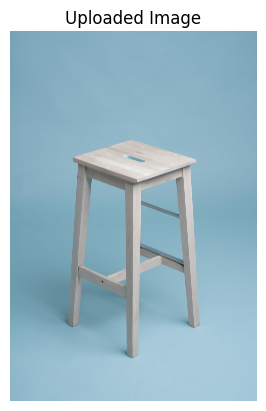

Removing background...


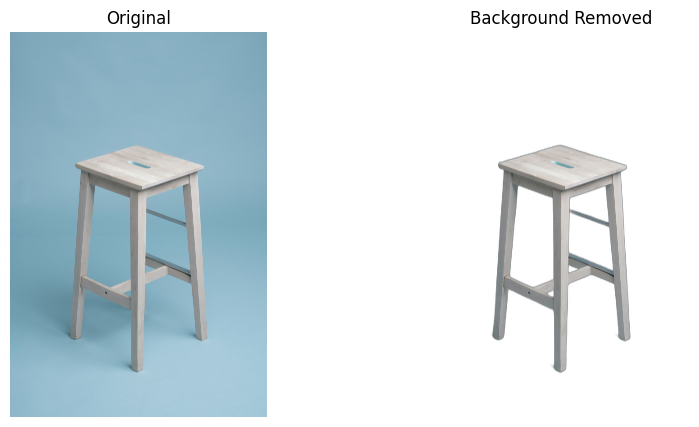

Using device: cuda


  0%|          | 0/64 [00:00<?, ?it/s]

Exporting mesh using transmitter model...
OBJ file saved as: ruslan-bardash-4kTbAMRAHtQ-unsplash (7).obj


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Visualizing 3D model from multiple angles...


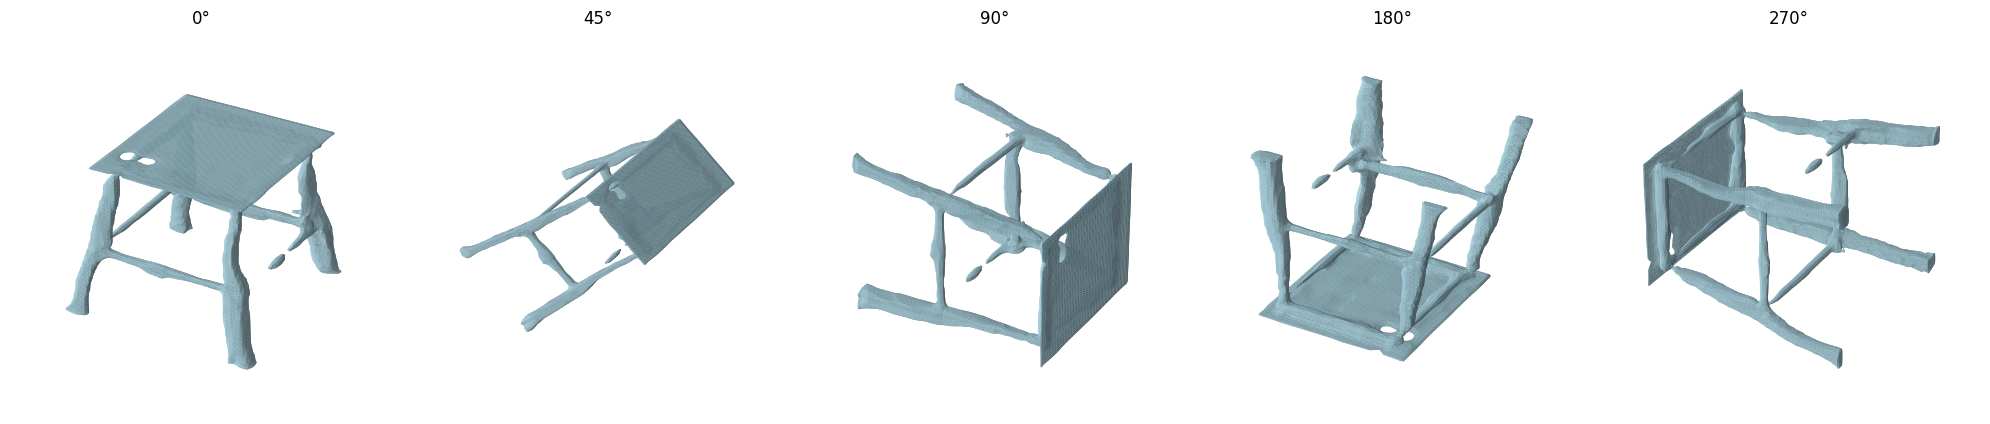


✅ Process Complete: 3D model generated and downloaded.


In [35]:
main()